In [10]:
"""
Lorenzo Speri, Lucas Pouw
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma, norm
from scipy.integrate import cumulative_trapezoid
from tqdm import tqdm
from utils import make_nice_plots
from scipy.interpolate import interp1d
from scipy.stats import binom
make_nice_plots()


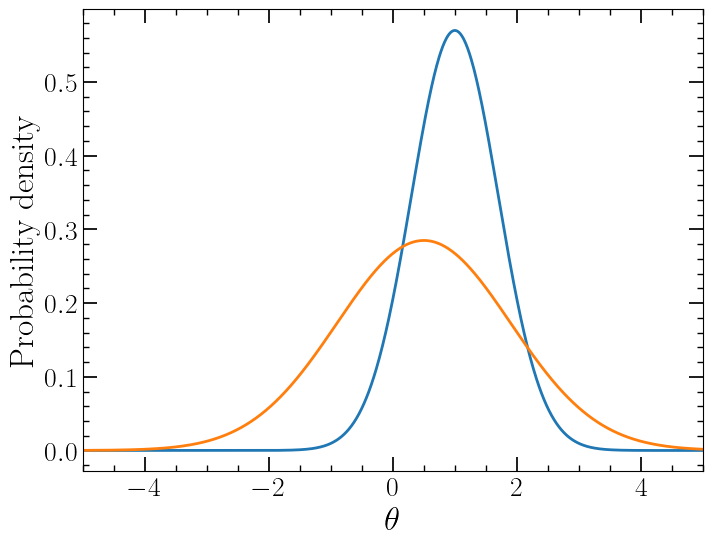

In [11]:
# --- Simulation parameters ---
N = 100                 # number of data points per experiment
n_exp = int(1e3)        # number of experiments
f_true = 0.1            # true fraction

# Define overlapping underlying distributions for x
mu_a = 1.0
mu_o = 0.5
sigma_a = 0.7           # Chosen for Sa values ~0.4-0.6 range/mean
sigma_o = 1.4           # Chosen for So values ~0.2 mean

xx = np.linspace(-5, 5, 1000)
plt.figure(figsize=(8,6))
plt.plot(xx, norm.pdf(xx, mu_a, sigma_a), linewidth=2)
plt.plot(xx, norm.pdf(xx, mu_o, sigma_o), linewidth=2)
plt.ylabel('Probability density')
plt.xlabel(r'$\theta$')
plt.xlim(-5, 5)
plt.show()


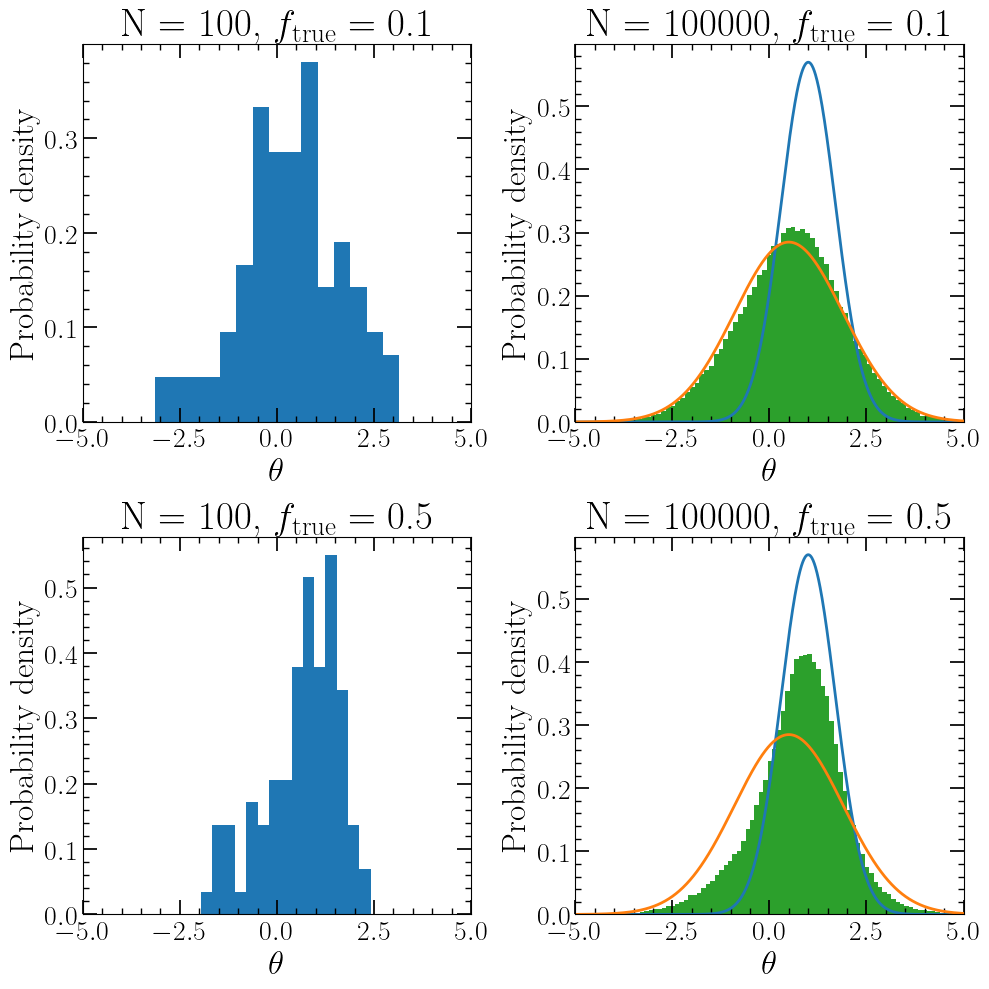

In [12]:
def generate_mixture_data(N, f_true=f_true, mu_a=mu_a, sigma_a=sigma_a, mu_o=mu_o, sigma_o=sigma_o):
    is_a = np.random.rand(N) < f_true
    # is_a = np.random.binomial(1, f_true, size=N).astype(bool)

    data = np.zeros(N)
    data[is_a] = norm.rvs(loc=mu_a, scale=sigma_a, size=is_a.sum())
    data[~is_a] = norm.rvs(loc=mu_o, scale=sigma_o, size=(~is_a).sum())
    return data


fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(10, 10))
ax1[0].hist(generate_mixture_data(N), bins=15, density=True)
ax1[0].set_ylabel('Probability density')
ax1[0].set_xlabel(r'$\theta$')
ax1[0].set_xlim(-5, 5)
ax1[0].set_title(f'N = {N}' + r', $f_{\rm true}$ = ' + str(f_true))

ax1[1].plot(xx, norm.pdf(xx, mu_a, sigma_a), linewidth=2)
ax1[1].plot(xx, norm.pdf(xx, mu_o, sigma_o), linewidth=2)
ax1[1].hist(generate_mixture_data(int(1e5)), bins=100, density=True)
ax1[1].set_ylabel('Probability density')
ax1[1].set_xlabel(r'$\theta$')
ax1[1].set_xlim(-5, 5)
ax1[1].set_title(f'N = {int(1e5)}' + r', $f_{\rm true}$ = ' + str(f_true))

ax2[0].hist(generate_mixture_data(N, f_true=0.5), bins=15, density=True)
ax2[0].set_ylabel('Probability density')
ax2[0].set_xlabel(r'$\theta$')
ax2[0].set_xlim(-5, 5)
ax2[0].set_title(f'N = {N}' + r', $f_{\rm true}$ = ' + str(0.5))

ax2[1].plot(xx, norm.pdf(xx, mu_a, sigma_a), linewidth=2)
ax2[1].plot(xx, norm.pdf(xx, mu_o, sigma_o), linewidth=2)
ax2[1].hist(generate_mixture_data(int(1e5), f_true=0.5), bins=100, density=True)
ax2[1].set_ylabel('Probability density')
ax2[1].set_xlabel(r'$\theta$')
ax2[1].set_xlim(-5, 5)
ax2[1].set_title(f'N = {int(1e5)}' + r', $f_{\rm true}$ = ' + str(0.5))
plt.tight_layout()
plt.show()


We need to set up a model consistent with the data generating process. The population model is:
\begin{equation}
    p_{\rm pop}(d_{i} | f_{\rm true}, \mu_{\rm a}, \sigma_{\rm a}, \mu_{\rm o}, \sigma_{\rm o}) = f_{\rm true} \mathcal{G}(\mu_{\rm a}, \sigma_{\rm a}) + (1 - f_{\rm true}) \mathcal{G}(\mu_{\rm o}, \sigma_{\rm o})
\end{equation}

The full hierarchical likelihood for this problem is:
\begin{equation}
    p(\Lambda | \{d\}) = \prod_{i=1}^{N} \int \mathrm{d} \theta \, p(d_{i}|\theta) p_{\rm pop}(\theta | \Lambda)
\end{equation}

The full set of population parameters is $\Lambda = \{f_{\rm true}, \mu_{\rm a}, \sigma_{\rm a}, \mu_{\rm o}, \sigma_{\rm o}\}$, but in this example we assume all but $f_{\rm true}$ known. Therefore, we are interested in:
\begin{equation}
    p(f_{\rm true} | \{d\}) = \prod_{i=1}^{N} \int \mathrm{d} \theta \, p(d_{i}|\theta) p_{\rm pop}(\theta | f_{\rm true})
\end{equation}

Moreover, we assume small measurement errors on our data, i.e., $p(d_{i}|\theta) = \delta(d_{i} - \theta)$, such that
\begin{equation}
    p(f_{\rm true} | \{d\}) = \prod_{i=1}^{N} p_{\rm pop}(d_{i} | f_{\rm true})
\end{equation}

We will now discuss the construction of an estimator for $f_{\rm true}$.

In [13]:
# --- Perform experiment many times, save posteriors ---
f_grid = np.linspace(0, 1, 1000)

log_posteriors = np.zeros((n_exp, len(f_grid)))
for i in tqdm(range(n_exp)):
    data = generate_mixture_data(N)
    
    # Compute p_pop(d_i | f_true)
    pop_a_evidence = norm.pdf(data, loc=mu_a, scale=sigma_a)
    pop_o_evidence = norm.pdf(data, loc=mu_o, scale=sigma_o)
    
    p_pop = f_grid[:, None] * pop_a_evidence + (1 - f_grid[:, None]) * pop_o_evidence
    # p_pop = np.maximum(p_pop, 1e-300)  # Clip to avoid log(0)

    log_L = np.sum(np.log(p_pop), axis=1)
    log_posteriors[i,:] = log_L  # Uniform prior!


100%|██████████| 1000/1000 [00:00<00:00, 4021.45it/s]


1000it [00:00, 102877.21it/s]


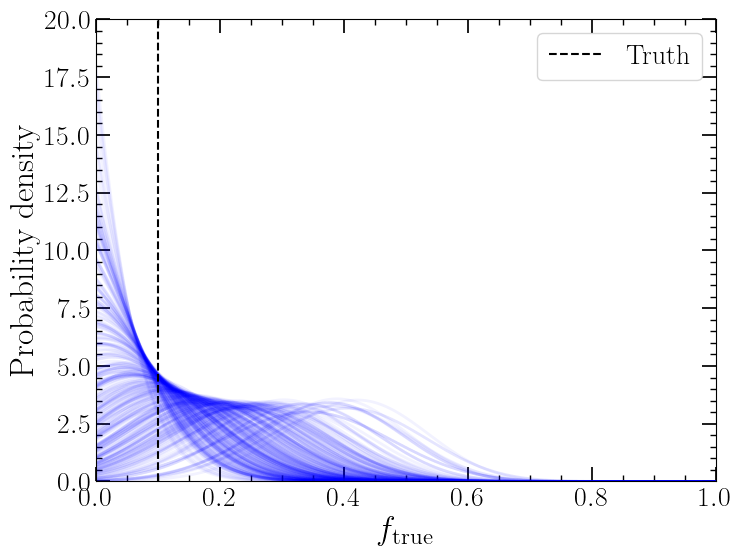

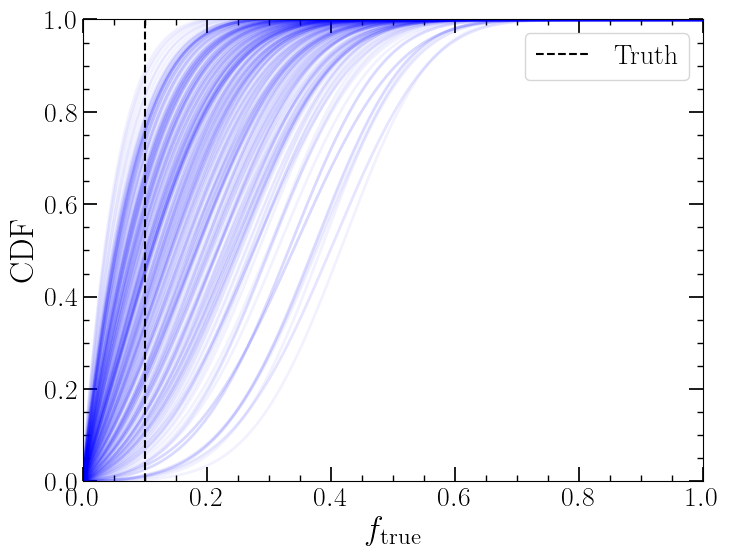

In [14]:
normalized_posteriors = np.zeros_like(log_posteriors)
for i, logpost in tqdm(enumerate(log_posteriors)):
    logpost -= np.max(logpost)
    logpost = np.exp(logpost)
    normalized_posteriors[i,:] = logpost / np.trapezoid(logpost, x=f_grid)

plot_these = np.random.choice(np.arange(n_exp), size=300)
post2plot = normalized_posteriors[plot_these,:]

plt.figure(figsize=(8,6))
plt.plot(f_grid, post2plot.T, alpha=0.05, color='blue', linewidth=2)
plt.vlines(f_true, 0, 20, linestyles='dashed', color='black', label='Truth')
plt.ylabel('Probability density')
plt.xlabel(r'$f_{\rm true}$')
plt.xlim(0, 1)
plt.ylim(0, 20)
plt.legend()
plt.show()

cdfs = np.cumsum(normalized_posteriors, axis=1) / normalized_posteriors.shape[1]

plt.figure(figsize=(8,6))
plt.plot(f_grid, cdfs[plot_these,:].T, alpha=0.05, color='blue', linewidth=2)
plt.vlines(f_true, 0, 1, linestyles='dashed', color='black', label='Truth')
plt.ylabel('CDF')
plt.xlabel(r'$f_{\rm true}$')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.show()


1000it [00:00, 10811.65it/s]


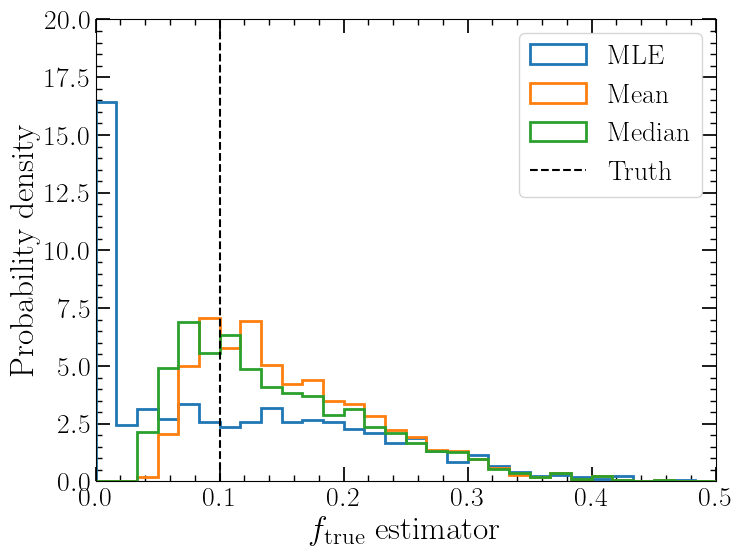

In [15]:
# --- Construct estimators ---
mle = f_grid[np.argmax(normalized_posteriors, axis=1)]  # MLE = f_true at maximum likelihood
post_mean = np.trapezoid(f_grid * normalized_posteriors, f_grid)  # Expectation value = int x p(x) dx
post_median = np.zeros(n_exp)  # Median = 50th percentile = value where CDF = 0.5

# --- Validation ---
cdf_at_true_val = np.zeros(n_exp)
cdf_at_mle = np.zeros(n_exp)
cdf_at_mean = np.zeros(n_exp)
cdf_at_median = np.zeros(n_exp)
q005 = np.zeros(n_exp)
q095 = np.zeros(n_exp)
for i, cdf in tqdm(enumerate(cdfs)):
    inverse_cdf = interp1d(cdf, f_grid, bounds_error=False, fill_value='extrapolate')
    post_median[i] = inverse_cdf(0.5)

    cdf_at_true_val[i] = interp1d(f_grid, cdf)(f_true)
    cdf_at_mle[i] = interp1d(f_grid, cdf)(mle[i])
    cdf_at_mean[i] = interp1d(f_grid, cdf)(post_mean[i])
    cdf_at_median[i] = interp1d(f_grid, cdf)(post_median[i])
    q005[i] = inverse_cdf(0.05)
    q095[i] = inverse_cdf(0.95)

edges = np.linspace(0, 0.5, 31)
fig, ax1 = plt.subplots(1, 1, figsize=(8,6))
ax1.hist(mle, density=True, bins=edges, histtype='step', linewidth=2, label='MLE')
ax1.hist(post_mean, density=True, bins=edges, histtype='step', linewidth=2, label='Mean')
ax1.hist(post_median, density=True, bins=edges, histtype='step', linewidth=2, label='Median')
ax1.set_xlim(edges[0], edges[-1])
ax1.set_ylim(0, 20)
ax1.vlines(f_true, 0, 35, linestyles='dashed', color='black', label='Truth')
ax1.legend()
ax1.set_xlabel(r'$f_{\rm true}$ estimator')
ax1.set_ylabel('Probability density')
plt.show()


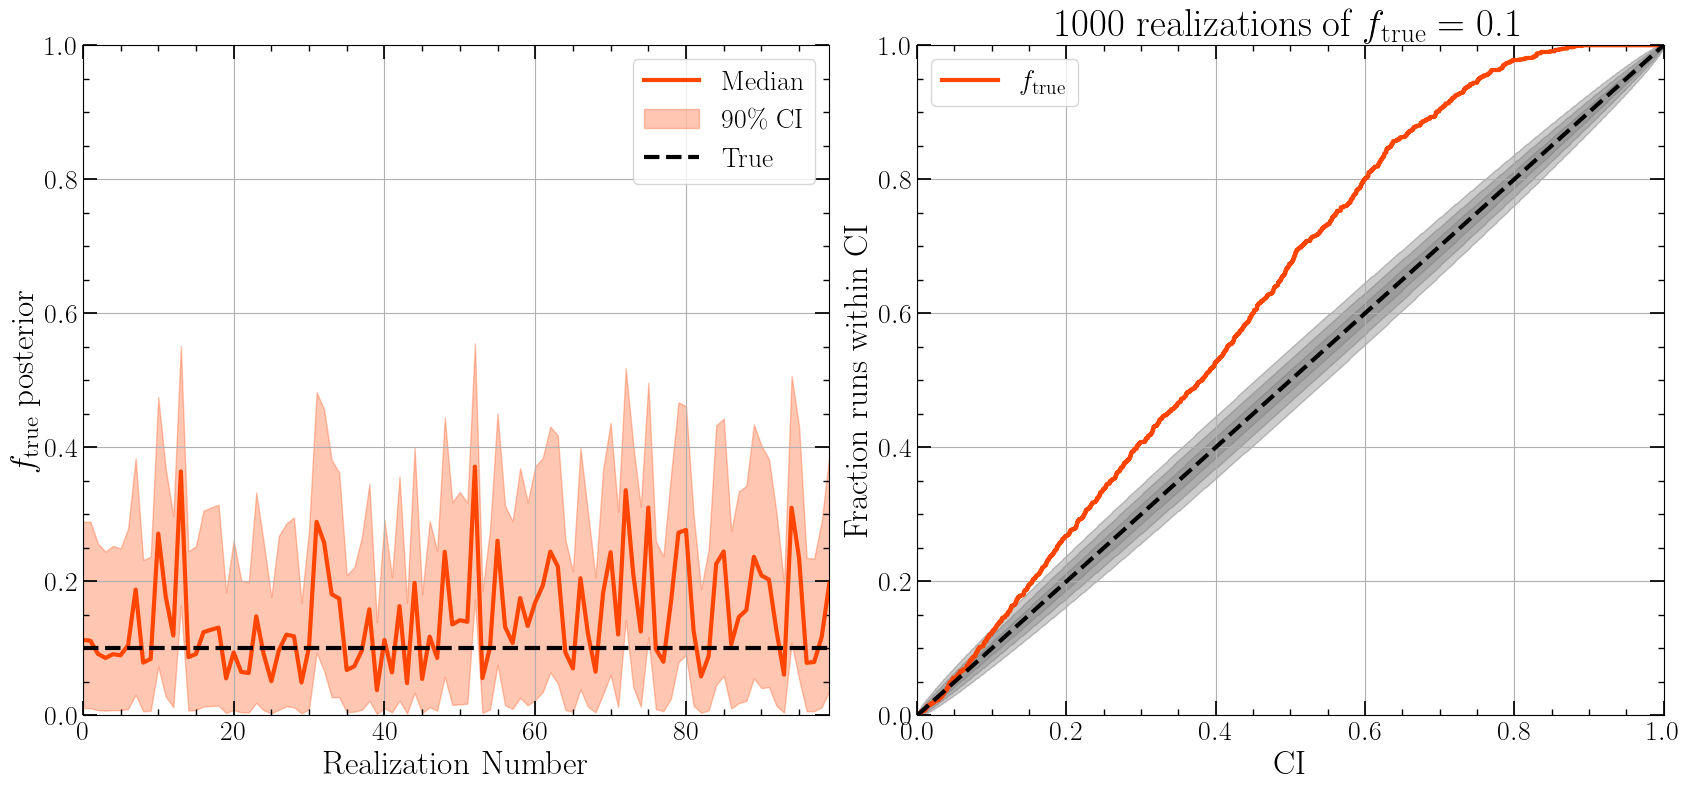

In [16]:
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,8))

every = 10
nx = normalized_posteriors.shape[0] / every
xx = np.arange(nx)

ax1.plot(xx, post_median[::every], color='orangered', linewidth=3, label='Median')
ax1.fill_between(xx, q005[::every], q095[::every], color='orangered', alpha=0.3, label=r'90$\%$ CI')
ax1.hlines(f_true, 0, nx - 1, linestyle='dashed', color='black', zorder=6, linewidth=3, label='True')
ax1.legend()
ax1.set_xlabel(r'Realization Number')
ax1.set_ylabel(r'$f_{\rm true}$ posterior')
ax1.grid()
ax1.set_xlim(0, nx - 1)
ax1.set_ylim(0, 1)

Nrep = len(cdf_at_true_val)
comparisons = np.linspace(0, 1, Nrep)
pp_plot_true = np.zeros(Nrep)
pp_plot_mle = np.zeros(Nrep)
pp_plot_mean = np.zeros(Nrep)
pp_plot_median = np.zeros(Nrep)
for i in range(Nrep):
    pp_plot_true[i] = np.sum(cdf_at_true_val <= comparisons[i])
    pp_plot_mle[i] = np.sum(cdf_at_mle <= comparisons[i])
    pp_plot_mean[i] = np.sum(cdf_at_mean <= comparisons[i])
    pp_plot_median[i] = np.sum(cdf_at_median <= comparisons[i])
pp_plot_true /= len(cdf_at_true_val)
pp_plot_mle /= len(pp_plot_mle)
pp_plot_mean /= len(pp_plot_mean)
pp_plot_median /= len(pp_plot_median)

CI = np.linspace(0, 0.9999, 1000)
for ci, alpha in zip([0.6827, 0.9545, 0.9973], [0.1,0.15,0.2]):
    edge_of_bound = (1. - ci) / 2.
    lower = binom.ppf(1 - edge_of_bound, Nrep, CI) / Nrep
    upper = binom.ppf(edge_of_bound, Nrep, CI) / Nrep
    lower[0] = 0
    upper[0] = 0
    plt.fill_between(CI, lower, upper, alpha=alpha, color='k')

ax2.plot(np.linspace(0,1,100), np.linspace(0,1,100), linestyle='dashed', color='black', zorder=6, linewidth=3)
ax2.step(comparisons, pp_plot_true, linewidth=3, color='orangered', label=r'$f_{\rm true}$')
# ax2.step(comparisons, pp_plot_mle, linewidth=3, color='navy', label='MLE')
# ax2.step(comparisons, pp_plot_mean, linewidth=3, color='teal', label='Mean')
# ax2.step(comparisons, pp_plot_median, linewidth=3, color='goldenrod', label='Median')
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.grid()
ax2.set_title(str(Nrep) + ' realizations of ' + r'$f_{\rm true} =$ ' + str(f_true))
ax2.set_xlabel('CI')
ax2.set_ylabel('Fraction runs within CI')
ax2.legend()
plt.tight_layout()
plt.show()
